In [49]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import CategoricalNB

In [50]:
cols = ["HomePlanet", "CryoSleep", "Destination", "Age", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Deck_Cabin", "Side_Cabin"]
labelCols = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck_Cabin", "Side_Cabin"]
numericalCols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
def preprocessingData(data):
    """
    The PassengerId and Name features don't provide any useful information that can help us predict the 
    Transported feature. The Cabin feature takes the form Deck/Num/Side. The Num part isn't too relevant 
    but the Deck and Side parts might be useful in predicting the Transported feature.
    """
    cabinSplit = data['Cabin'].str.split("/", expand=True)
    data['Deck_Cabin'] = cabinSplit[0]
    data['Side_Cabin'] = cabinSplit[2]
    data = data.drop(columns=["PassengerId", "Name", "Cabin"])
    
    #Filling the nan values in every numerical feature except Age with the mode value
    #Filling the nan values in the Age feature with the mean value
    #Standardizing the numerical columns so that all the values in these columns are on the same numerical scale
    #Filling the nan values in these categorical features with the mode value
    #Transforming the categorical features to store int labels
    label_encoder = preprocessing.LabelEncoder()
    for col in cols:
        if col in numericalCols:
            if col == "Age":
                data[col] = data[col].fillna(data[col].mean())
            else:
                data[col] = data[col].fillna(data[col].mode()[0])
            data[col] = (data[col] - data[col].mean())/(data[col].std())
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            data[col] = label_encoder.fit_transform(data[col])
            data[col] = data[col].astype(int)
               
    return data


In [51]:
data = pd.read_csv("train.csv")
data = preprocessingData(data)
data["Transported"] = data["Transported"].replace(False, 0).replace(True, 1)
X = data.drop(['Transported'],axis=1)
y = data['Transported']

#Naive Bayes Assumption 1 — There is almost no correlation among the features.
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    cols = data.columns
    i = 0
    for col in cols:
        y = data[col]
        x = data[cols.drop([col])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = 1/(1-r_squared)
        vif_df.loc[i] = [col, vif]
        i += 1
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

"""
The Vif value for the Deck_Cabin feature is close to 5 which is not ideal as seen in the first output 
generated below so we should remove it.
"""
print(calculate_vif(X), "\n")

X = X.drop(['Deck_Cabin'],axis=1)
cols.remove("Deck_Cabin")
labelCols.remove("Deck_Cabin")

"""
After removing the Deck_Cabin feature no VIF values are close to 5 as seen in the second output generated below
indicating that there's very little correlation among the features.
"""
print(calculate_vif(X))

             Var       Vif
10    Deck_Cabin  4.459733
2    Destination  4.172456
11    Side_Cabin  1.921506
1      CryoSleep  1.892311
0     HomePlanet  1.842556
6      FoodCourt  1.157605
5    RoomService  1.152064
9         VRDeck  1.105774
8            Spa  1.098387
3            Age  1.070050
7   ShoppingMall  1.070041
4            VIP  1.066810 

             Var       Vif
2    Destination  2.077844
0     HomePlanet  1.818066
1      CryoSleep  1.778076
10    Side_Cabin  1.753161
6      FoodCourt  1.151450
5    RoomService  1.149643
9         VRDeck  1.102974
8            Spa  1.097130
7   ShoppingMall  1.068983
4            VIP  1.066810
3            Age  1.050240


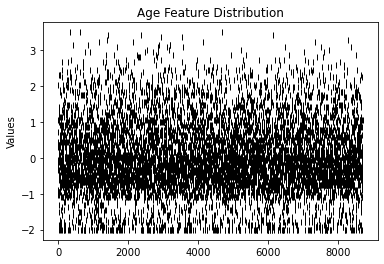

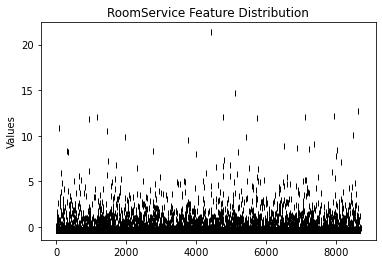

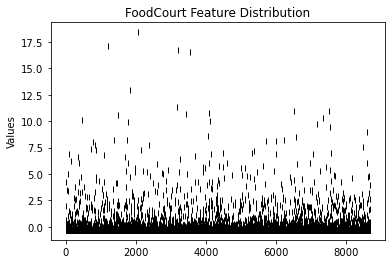

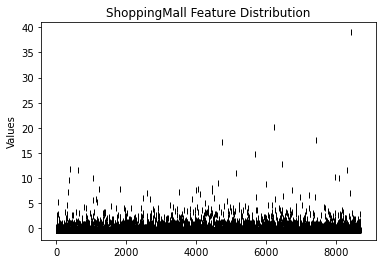

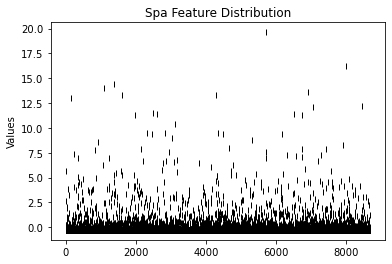

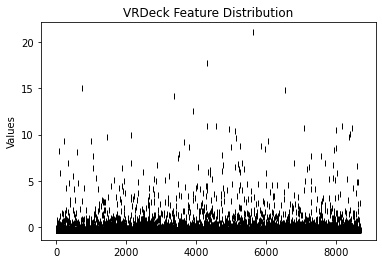

In [52]:
#Naive Bayes Assumption 2 — Each Feature is Equal in Terms of Weightage and Importance
"""
There's no further data preprocessing that we can do for this assumption and we must assume that this 
assumption is met when using this algorithm.
"""

#Naive Bayes Assumption 3 - The Features are Conditionally Independent of Each Other
"""
There's no further data preprocessing that we can do for this assumption but from reading the description
of each feature in the Kaggle Competition dataset description, we can assume that this assumption is met 
when using this algorithm.
"""

#Naive Bayes Assumption 4 - Each Numerical Feature Follows a Normal Distribution
"""
This assumption is rarely met in most practical cases and there's no further data preprocessing that we can
do to fix this. Therefore, we will continue using the Naive Bayes algorithm even though the assumption is not 
met by the data.
"""
for col in cols:
    if col in numericalCols:
        plt.plot(data[col], '|k')
        plt.title(col + " Feature Distribution")
        plt.ylabel("Values")
        plt.show()

In [53]:
"""
We aren't using the Multinomial Naive Bayes or Complement Naive Bayes algorithms provided by the 
sklearn.naive_bayes library because these two algorithms are best suited for features that are 
related to word counts or frequencies of words within documents to be classified. None of the 
features in our dataset represent counts so we will therefore not consider these algorithms. We also 
aren't using the Bernoulli Naive Bayes algorithm provided by the sklearn.naive_bayes library because 
this algorithm is best suited for features that only have two categories. Some of the features in our 
dataset have only two categories but not all of them do which is why we also won't consider this 
algorithm as well.

The Gaussian Naive Bayes algorithm from the sklearn.naive_bayes library is suited for continuous data and
the Categorical Naive Bayes algorithm from the sklearn.naive_bayes library is suited for categorical data.
In our dataset we have both categorical and numerical data so one way we can handle this is by transforming 
all the numerical data into a categorical representation and then using the Categorical Naive Bayes algorithm 
to train the dataset and make predictions on the test set.
"""

"\nWe aren't using the Multinomial Naive Bayes or Complement Naive Bayes algorithms provided by the \nsklearn.naive_bayes library because these two algorithms are best suited for features that are \nrelated to word counts or frequencies of words within documents to be classified. None of the \nfeatures in our dataset represent counts so we will therefore not consider these algorithms. We also \naren't using the Bernoulli Naive Bayes algorithm provided by the sklearn.naive_bayes library because \nthis algorithm is best suited for features that only have two categories. Some of the features in our \ndataset have only two categories but not all of them do which is why we also won't consider this \nalgorithm as well.\n\nThe Gaussian Naive Bayes algorithm from the sklearn.naive_bayes library is suited for continuous data and\nthe Categorical Naive Bayes algorithm from the sklearn.naive_bayes library is suited for categorical data.\nIn our dataset we have both categorical and numerical data 

In [54]:
#Transforming the numerical features into categorical features
label_encoder = preprocessing.LabelEncoder()
def categoricalTransformation(data):
    for col in data.columns:
        if col in numericalCols:
            new_df = pd.qcut(data[col], q=5, duplicates='drop')
            new_df = new_df.astype(str)
            data[col] = new_df
            data[col] = label_encoder.fit_transform(data[col])
            data[col] = data[col].astype(int)
    return data

X = categoricalTransformation(X)

"""
According to online sources, hyperparameter tuning is not useful for the Naive Bayes algorithm so we won't perform
any hyperparameter tuning.
"""

model = CategoricalNB()
y_pred = model.fit(X, y).predict(X)
accuracy_train = accuracy_score(y,y_pred)
print('Accuracy on training dataset : ', accuracy_train)


Accuracy on training dataset :  0.7502588289428276


In [55]:
"""
Precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
Recall is intuitively the ability of the classifier to find all the positive samples.
F1-score can be interpreted as a weighted harmonic mean of the precision and recall, where an F1-score 
reaches its best value at 1 and its worst score at 0.
"""
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.81      0.76      4315
         1.0       0.79      0.69      0.74      4378

    accuracy                           0.75      8693
   macro avg       0.75      0.75      0.75      8693
weighted avg       0.75      0.75      0.75      8693



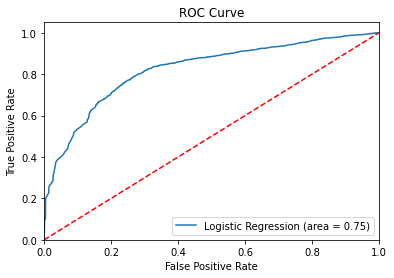

In [56]:
"""
The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away 
from that line as possible
"""
logit_roc_auc = roc_auc_score(y, y_pred)
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [57]:
#Final predictions on the test set to provide for submission
test_data = pd.read_csv("test.csv")
passenger_ids = test_data["PassengerId"]
test_data = preprocessingData(test_data)
test_data = test_data.drop(['Deck_Cabin'],axis=1)
test_data = categoricalTransformation(test_data)
y_pred = model.predict(test_data)

final_submission = pd.DataFrame()
final_submission["PassengerId"] = passenger_ids
final_submission["Transported"] = y_pred
final_submission["Transported"] = final_submission["Transported"].replace(0, False).replace(1, True)
final_submission.to_csv('NaiveBayesSubmission.csv', index=False)
#Final Submission Produced an accuracy of 0.76151 on the test set